In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
bank_df = pd.read_csv("D:\\DataSets\\Machine Learning (Codes and Data Files)\\Data\\bank.csv")
bank_df.head()

,age,job,marital,education,default,balance,housing-loan,personal-loan,current-campaign,previous-campaign,subscribed
0,30,unemployed,married,primary,no,1787,no,no,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,1,0,no


In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
age                  4521 non-null int64
job                  4521 non-null object
marital              4521 non-null object
education            4521 non-null object
default              4521 non-null object
balance              4521 non-null int64
housing-loan         4521 non-null object
personal-loan        4521 non-null object
current-campaign     4521 non-null int64
previous-campaign    4521 non-null int64
subscribed           4521 non-null object
dtypes: int64(4), object(7)
memory usage: 388.6+ KB


# Dealing with imbalanced datasets

In [4]:
bank_df.subscribed.value_counts() 

no     4000
yes     521
Name: subscribed, dtype: int64

In [5]:
from sklearn.utils import resample

bank_subscribed_no = bank_df[bank_df.subscribed == 'no'] 
bank_subscribed_yes = bank_df[bank_df.subscribed == 'yes'] 

##Upsample the yes-subscribed cases
df_minority_upsampled = resample(bank_subscribed_yes, replace=True,     # sample with replacement 
                                 n_samples=2000) 

new_bank_df = pd.concat([bank_subscribed_no, df_minority_upsampled]) 

In [6]:
from sklearn.utils import shuffle 

new_bank_df = shuffle(new_bank_df) 

In [7]:
# Assigning list of all column names in the DataFrame 
X_features = list( new_bank_df.columns ) 
# Remove the response variable from the list 
X_features.remove( 'subscribed' ) 
X_features 

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

In [8]:
## get_dummies() will convert all the columns with data type as objects 

encoded_bank_df = pd.get_dummies( new_bank_df[X_features], drop_first = True ) 
X = encoded_bank_df 

In [9]:
# Encoding the subscribed column and assigning to Y 

Y = new_bank_df.subscribed.map( lambda x: int( x == 'yes') ) 

In [10]:
#We are splitting the model as train and test data with 70-30 ratio

from sklearn.model_selection import train_test_split 
train_X, test_X, train_y, test_y = train_test_split( X, Y, test_size = 0.3, random_state = 42)

#  Logistic Regression model

In [11]:
from sklearn.linear_model import LogisticRegression 

logit = LogisticRegression()
logit.fit( train_X, train_y) 
pred_y = logit.predict(test_X) 

In [12]:
from sklearn import metrics 

def draw_cm( actual, predicted ): 
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
    
    sns.heatmap(cm, annot=True,  fmt='.2f',  
                xticklabels = ["Subscribed", "Not Subscribed"], 
                yticklabels = ["Subscribed", "Not Subscribed"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

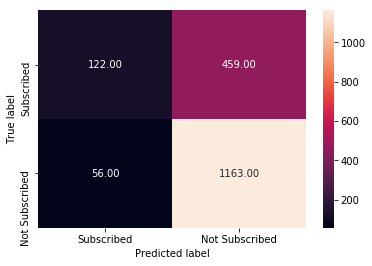

In [13]:
cm = draw_cm(test_y, pred_y )
cm 

In [14]:
print( metrics.classification_report(test_y, pred_y)) 

              precision    recall  f1-score   support

           0       0.72      0.95      0.82      1219
           1       0.69      0.21      0.32       581

   micro avg       0.71      0.71      0.71      1800
   macro avg       0.70      0.58      0.57      1800
weighted avg       0.71      0.71      0.66      1800



In [15]:
## Predicting the probability values for test cases 

predict_proba_df = pd.DataFrame(logit.predict_proba(test_X)) 
predict_proba_df.head() 

,0,1
0,0.825798,0.174202
1,0.848639,0.151361
2,0.528274,0.471726
3,0.711339,0.288661
4,0.727495,0.272505


In [16]:
## Initializing the DataFrame with actual class lables 
test_results_df = pd.DataFrame( { 'actual': test_y } ) 
test_results_df = test_results_df.reset_index()

## Assigning the probability values for class label 1 
test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2] 

In [17]:
test_results_df.head(5) 

,index,actual,chd_1
0,4114,0,0.174202
1,1890,0,0.151361
2,1425,1,0.471726
3,3967,0,0.288661
4,4490,0,0.272505


In [20]:
# Passing actual class labels and the predicted probability values to compute RO C AUC score.

auc_score = metrics.roc_auc_score(test_results_df.actual, test_results_df.chd_1)
auc_scor

0.6991312254761457

In [21]:
fpr, tpr, thresholds = metrics.roc_curve( test_results_df.actual, 
                                          test_results_df.chd_1, drop_intermediate = False ) 

In [28]:
def draw_roc_curve( model, test_X, test_y ):
    test_results_df = pd.DataFrame( { 'actual':  test_y } )    
    test_results_df = test_results_df.reset_index() 
    
    predict_proba_df = pd.DataFrame( model.predict_proba( test_X ) )
    test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2] 
    
    fpr, tpr, thresholds = metrics.roc_curve( test_results_df.actual, test_results_df.chd_1, 
                                             drop_intermediate = False ) 
    
    auc_score = metrics.roc_auc_score( test_results_df.actual, test_results_df.chd_1)
    
    plt.figure(figsize=(8, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) 
    
    
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')   
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")    
    plt.show() 
    
    return auc_score, fpr, tpr, thresholds

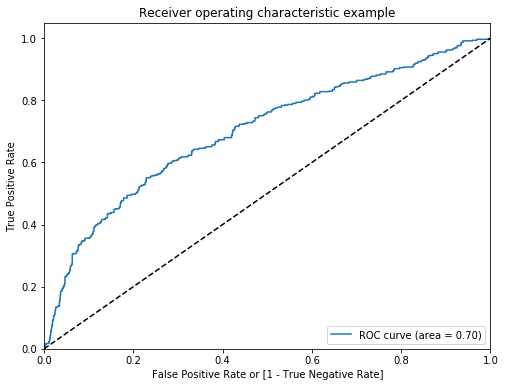

In [29]:
## Invoking draw_roc_curve with the logistic regresson model 
_, _, _, _ = draw_roc_curve( logit, test_X, test_y ) 

# K-Nearest Neighbour

In [30]:
from sklearn.neighbors import KNeighborsClassifier 

knn_clf = KNeighborsClassifier()
knn_clf.fit(train_X, train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

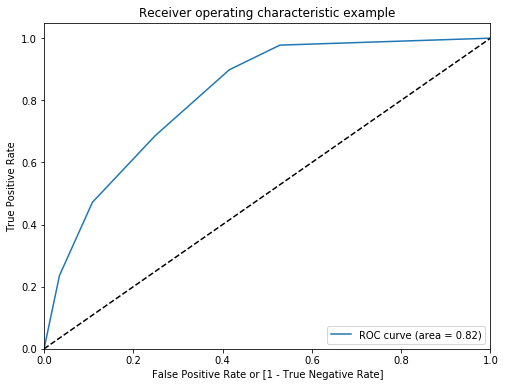

In [31]:
_, _, _, _ = draw_roc_curve( knn_clf, test_X, test_y )

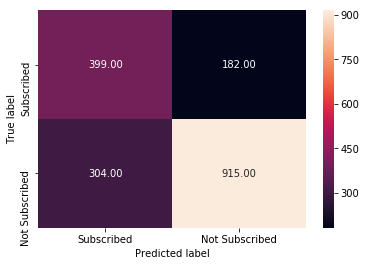

In [33]:
pred_y = knn_clf.predict(test_X) 

draw_cm( test_y, pred_y) 

In [34]:
print( metrics.classification_report( test_y, pred_y )) 

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1219
           1       0.57      0.69      0.62       581

   micro avg       0.73      0.73      0.73      1800
   macro avg       0.70      0.72      0.71      1800
weighted avg       0.75      0.73      0.74      1800



# GridSerach for most optimal parameters

In [40]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'n_neighbors': range(5,10),  
                     'metric': ['canberra', 'euclidean', 'minkowski']}] 
clf = GridSearchCV(KNeighborsClassifier(), 
                   tuned_parameters, cv=10, scoring='roc_auc') 

In [41]:
clf.fit(train_X, train_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': range(5, 10), 'metric': ['canberra', 'euclidean', 'minkowski']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [42]:
clf.best_score_ 

0.8221123690463787

In [43]:
clf.best_params_

{'metric': 'canberra', 'n_neighbors': 5}

# Ensemble methods

# Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier 

radm_clf = RandomForestClassifier( max_depth=10, n_estimators=10)
radm_clf.fit( train_X, train_y ) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

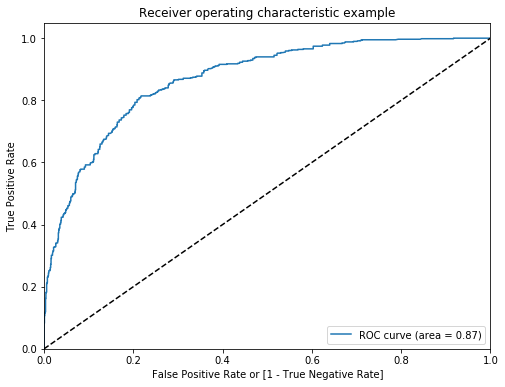

In [46]:
_, _, _, _ = draw_roc_curve( radm_clf, test_X, test_y )

# GridSerach for most optimal parameters

In [47]:
tuned_parameters = [{'max_depth': [10, 15], 
                     'n_estimators': [10,20], 
                     'max_features': ['sqrt', 'auto']}] 
radm_clf = RandomForestClassifier() 

clf = GridSearchCV(radm_clf, tuned_parameters, cv=5, scoring='roc_auc') 
clf.fit(train_X, train_y )

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [10, 15], 'n_estimators': [10, 20], 'max_features': ['sqrt', 'auto']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [48]:
clf.best_score_

0.9397481783302271

In [49]:
clf.best_params_ 

{'max_depth': 15, 'max_features': 'auto', 'n_estimators': 20}

# Building the ﬁnal model with optimal parameter values

In [50]:
radm_clf = RandomForestClassifier( max_depth=15, n_estimators=20, max_features = 'auto') 

radm_clf.fit( train_X, train_y ) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

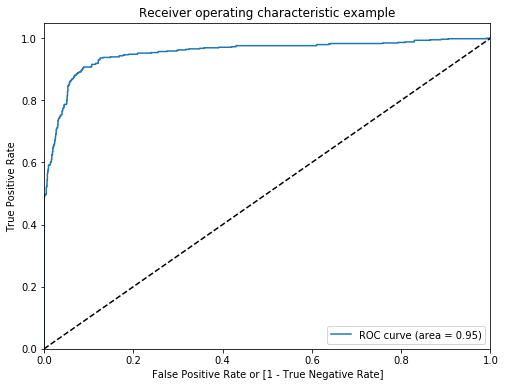

In [51]:
_, _, _, _ = draw_roc_curve( clf, test_X, test_y )

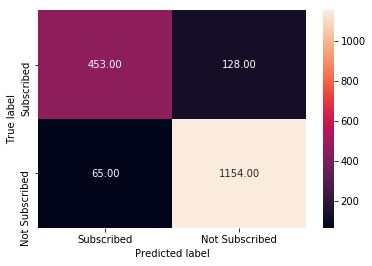

In [52]:
pred_y = radm_clf.predict( test_X )
draw_cm( test_y, pred_y )

In [53]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1219
           1       0.87      0.78      0.82       581

   micro avg       0.89      0.89      0.89      1800
   macro avg       0.89      0.86      0.87      1800
weighted avg       0.89      0.89      0.89      1800



#  Finding important features

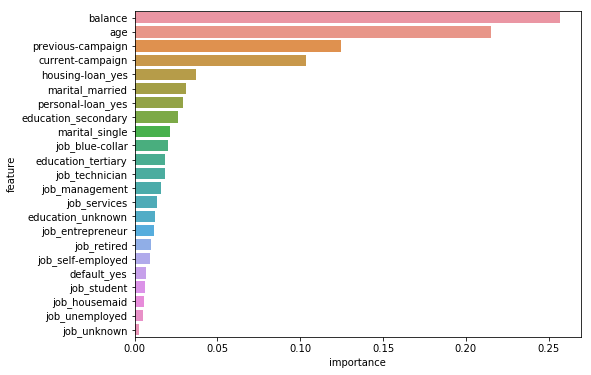

In [55]:
feature_rank = pd.DataFrame( { 'feature': train_X.columns, 'importance': radm_clf.feature_importances_ } ) 

feature_rank = feature_rank.sort_values('importance', ascending = False) 
plt.figure(figsize=(8, 6)) 

sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

In [57]:
feature_rank['cumsum'] = feature_rank.importance.cumsum() * 100 
feature_rank.head(10) 

,feature,importance,cumsum
1,balance,0.256679,25.667934
0,age,0.215198,47.187689
3,previous-campaign,0.124435,59.631165
2,current-campaign,0.103598,69.990991
21,housing-loan_yes,0.037215,73.712539
15,marital_married,0.030783,76.790792
22,personal-loan_yes,0.029034,79.694182
17,education_secondary,0.026008,82.295029
16,marital_single,0.021117,84.406743
4,job_blue-collar,0.020019,86.408601


# Boosting

#  1-Adaboost

In [58]:
from sklearn.ensemble import AdaBoostClassifier 

logreg_clf = LogisticRegression() 
ada_clf = AdaBoostClassifier(logreg_clf, n_estimators=50) 

ada_clf.fit(train_X, train_y )

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

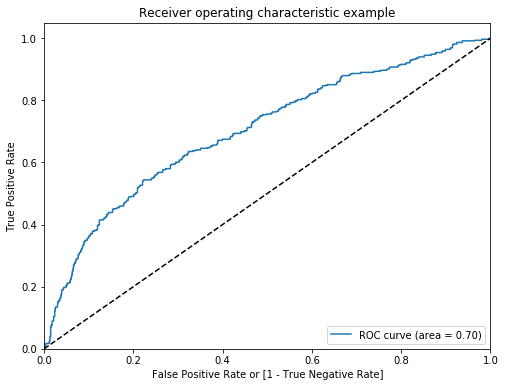

In [59]:
_, _, _, _ = draw_roc_curve( ada_clf, test_X, test_y )

# 2-Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

gboost_clf = GradientBoostingClassifier( n_estimators=500, max_depth=10) 
gboost_clf.fit(train_X, train_y ) 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

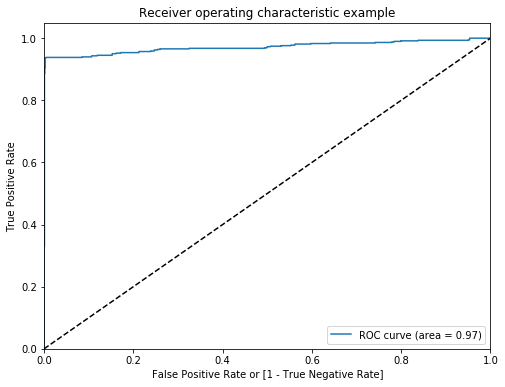

In [61]:
_, _, _, _ = draw_roc_curve( gboost_clf, test_X, test_y ) 

In [62]:
from sklearn.model_selection import cross_val_score 

gboost_clf = GradientBoostingClassifier( n_estimators=500, max_depth=10) 
cv_scores = cross_val_score( gboost_clf, train_X, train_y, cv = 10, scoring = 'roc_auc' ) 


In [63]:
print( cv_scores )
print( "Mean Accuracy: ", np.mean(cv_scores), " with standard deviation of: ",  np.std(cv_scores)) 

[0.99863698 0.98525686 0.97093171 0.97765731 0.98794204 0.96919647
 0.95584659 0.971603   0.96119161 0.95418134]
Mean Accuracy:  0.9732443914270308  with standard deviation of:  0.013639499337638066


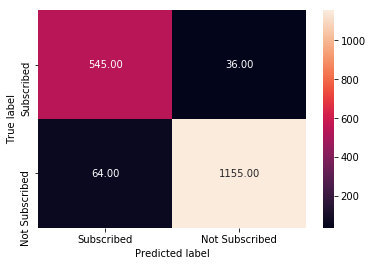

In [64]:
gboost_clf.fit(train_X, train_y ) 
pred_y = gboost_clf.predict( test_X ) 
draw_cm( test_y, pred_y ) 

In [65]:
print( metrics.classification_report( test_y, pred_y ))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1219
           1       0.89      0.94      0.92       581

   micro avg       0.94      0.94      0.94      1800
   macro avg       0.93      0.94      0.94      1800
weighted avg       0.95      0.94      0.94      1800



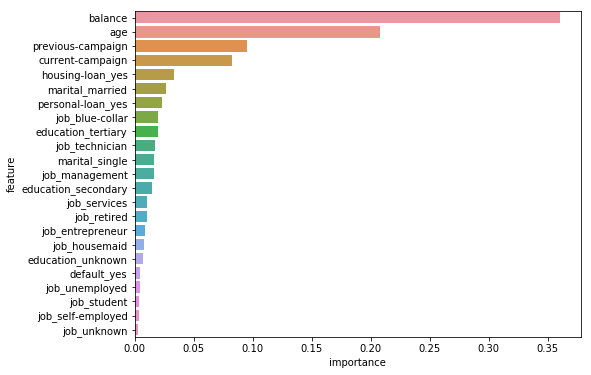

In [67]:
feature_rank = pd.DataFrame( { 'feature': train_X.columns, 'importance': gboost_clf.feature_importances_ } )

feature_rank = feature_rank.sort_values('importance', ascending = False) 
plt.figure(figsize=(8, 6)) 
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

# Conclusion